In [59]:
# import libraries
# python staples
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
# scikitlearn

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
# seaborn plotting
import seaborn as sns
# use matplot |in jupyter notebook
%matplotlib inline

In [78]:
def confusion_summary_binary(y_actual, y_pred, verbose):
    # get success and failur
    tot_tested = len(y_actual)
    tot_success = sum( y_actual )
    tot_fail = tot_tested - tot_success
    pred_success = sum( y_pred )
    pred_fail = tot_tested - pred_success
    # see how you did
    confusion_mat = confusion_matrix(y_actual, y_pred)
    confusion_mat_norm = confusion_mat / tot_tested
    accuracy = confusion_mat_norm[0,0] + confusion_mat_norm[1,1]
    recall = confusion_mat[0,0] / tot_success
    precision = confusion_mat[0,1] / pred_success
    f1 = 2 / ( 1/recall + 1/precision)
    summary = {"confusion": confusion_mat, "confusion_norm": confusion_mat_norm,
               "recall": recall, "precision": precision, "f1": f1,
               "accuracy": accuracy}
    if verbose == 1:
        print('accuracy = ', accuracy )
        print('recall = ', recall )
        print('precision = ', precision )
        print('f1 =', f1  )
    return summary

def clean_data( mydata, drop_list, verbose ):
    # some data is pointless, get rid of id
    mydata = mydata.drop( drop_list, axis=1 )
    # clean it
    # find isnan value
    if verbose == 1:
        print( 'before clean isnan check:\n', mydata.isna().any() )
    # turn male/female, embarked to a number
    mydata.loc[mydata.Sex == 'female','Sex' ] = 0
    mydata.loc[mydata.Sex == 'male','Sex' ] = 1
    mydata.loc[mydata.Embarked == 'S','Embarked' ] = 0
    mydata.loc[mydata.Embarked == 'C','Embarked' ] = 1
    mydata.loc[mydata.Embarked == 'Q','Embarked' ] = 2
    # replace nan with average
    mydata.loc[mydata.Age.isnull(),'Age']  = np.mean( mydata.Age[~mydata.Age.isna()] )
    mydata.loc[mydata.Fare.isnull(),'Fare']  = np.mean( mydata.Fare[~mydata.Fare.isna()] )
    mydata.loc[mydata.Embarked.isna(),'Embarked'] = mydata.mode().Embarked[0]
    #normalize
    mydata = ( mydata - mydata.mean() ) / mydata.std()
    if verbose:
        print('after clean isnan check:\n', mydata.isna().any() )
        print( 'Cleaned data:', mydata.iloc[0] )
    return mydata

def sklearn_fit( fitmodel, x_train, y_train, x_cv, y_cv, verbose ):
    fitmodel.fit(x_train, y_train)
    prediction = fitmodel.predict(x_cv)
    accuracy = get_accuracy( y_cv, prediction )
    model = {'prediction': prediction, 'accuracy': accuracy }
    return model

def get_accuracy( y_actual, y_pred ):
    return np.sum( y_actual == y_pred) / np.size( y_actual)

In [4]:
# grab the data and put it in a pandas dataframe
df_train_all = pd.read_csv('train.csv')
df_test_all = pd.read_csv('test.csv')
# print some info
print('Original train data set:\n\n', df_train_all.iloc[0])
print('Original test data set:\n\n', df_test_all.iloc[0])
num_features = len( df_train_all.columns ) - 1
print('\n features:', num_features )

Original train data set:

 PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                                 22
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object
Original test data set:

 PassengerId                 892
Pclass                        3
Name           Kelly, Mr. James
Sex                        male
Age                        34.5
SibSp                         0
Parch                         0
Ticket                   330911
Fare                     7.8292
Cabin                       NaN
Embarked                      Q
Name: 0, dtype: object

 features: 11


In [60]:
# clean data
drop_list = ['Parch','PassengerId','Name','Ticket', 'Cabin']
# break the y data to train, validation set
train_frac = 0.66;
num_tot = len( df_train_all.index)
num_train = np.round( num_tot * train_frac )
num_validation = num_tot - num_train;
ind_train = np.random.choice(int(num_tot), int(num_train), replace=False)
ind_all = np.arange(num_tot)
ind_cv = np.delete( ind_all, ind_train )
y_train = df_train_all.Survived.iloc[ind_train]
y_cv = df_train_all.Survived.iloc[ind_cv]
# clean it
df_data = clean_data( df_train_all, drop_list, 0)
df_data.Survived = y_train
# separate into training sets
x_data = df_data.drop( 'Survived', axis=1 )
x_train = x_data.iloc[ind_train]
x_cv = x_data.iloc[ind_cv]
x_test = clean_data( df_test_all, drop_list, 0)
# print some info
num_features_test = len( x_test.columns )
num_features_train = len( x_train.columns )
print( 'Data set:\n', x_train.iloc[0])
print( 'Data set:\n', x_test.iloc[0])
print('\n test samples:', len( df_test.index) )
print('\n train samples:', len( df_train.index) )
print('\n cv samples:', len( df_cv.index) )
print('\n features:', num_features_test, num_features_train )

Data set:
 Pclass     -1.565228
Sex         0.737281
Age         3.099587
SibSp       0.432550
Fare        0.780703
Embarked   -0.568518
Name: 745, dtype: float64
Data set:
 Pclass      0.872436
Sex         0.755024
Age         0.334592
SibSp      -0.498872
Fare       -0.497811
Embarked    2.240480
Name: 0, dtype: float64

 test samples: 418

 train samples: 588

 cv samples: 303

 features: 6 6


In [ ]:
sns.set(style="ticks")
sns.pairplot(df_train, hue='Survived')

Text(0.5,1,'PCA')

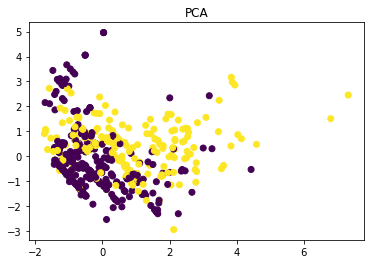

In [6]:
# Principal component analysis
# 2d
pca2 = PCA(n_components=2)
pca2.fit(x_train)
x_transform2 = pca2.transform(x_train)
plt.scatter( x_transform2[:,0], x_transform2[:,1], c = y_train )
plt.title('PCA')

In [21]:
# sci-kit learn logistic regression
logistic = linear_model.LogisticRegression()
logistic.fit(x_train, y_train)
#print(x_test.isna().any())
log_pred = logistic.predict(x_cv)
#log_correct = np.sum(log_pred == y_test) / np.size( y_test )
# f1, recall, precision test
log_sum = confusion_summary_binary( y_cv, log_pred, 1)
x = dir(logistic)
print(x)
print(logistic.__class__)

accuracy =  0.7854785478547854
recall =  1.2601626016260163
precision =  0.23148148148148148
f1 = 0.39111784002018674
['C', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_estimator_type', '_get_param_names', '_predict_proba_lr', 'class_weight', 'classes_', 'coef_', 'decision_function', 'densify', 'dual', 'fit', 'fit_intercept', 'get_params', 'intercept_', 'intercept_scaling', 'max_iter', 'multi_class', 'n_iter_', 'n_jobs', 'penalty', 'predict', 'predict_log_proba', 'predict_proba', 'random_state', 'score', 'set_params', 'solver', 'sparsify', 'tol', 'verbose', 'warm_start']
<class 'sklearn.linear_model.logistic.LogisticRegression'>
<bound method BaseEstimator._g

In [46]:
# Logistical fit using sm.Logit
logistic2 = sm.Logit(y_train, x_train)
# fit the model
result = logistic2.fit()
print( result.summary2() )
#print(result.params)
log2_pred = result.predict(x_cv)
# this regression return sigmoid hypothesis. Round it
log2_pred = np.int8( np.round(log_pred2) )
log2_sum = confusion_summary_binary( y_cv, log2_pred,1)


Optimization terminated successfully.
         Current function value: 0.467547
         Iterations 7
                        Results: Logit
Model:              Logit            No. Iterations:   7.0000  
Dependent Variable: Survived         Pseudo R-squared: 0.303   
Date:               2018-02-18 17:45 AIC:              561.8349
No. Observations:   588              BIC:              588.0953
Df Model:           5                Log-Likelihood:   -274.92 
Df Residuals:       582              LL-Null:          -394.40 
Converged:          1.0000           Scale:            1.0000  
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
Pclass     -0.8714    0.1496   -5.8243  0.0000  -1.1646  -0.5781
Sex        -1.2610    0.1171  -10.7730  0.0000  -1.4905  -1.0316
Age        -0.4858    0.1220   -3.9837  0.0001  -0.7249  -0.2468
SibSp      -0.3241   

In [8]:
# linear discriminant analysis
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
lda_pred = lda.predict(x_cv)
# f1, recall, precision test
lda_sum = confusion_summary_binary( y_cv, lda_pred, 1)

accuracy =  0.7986798679867987
recall =  1.490909090909091
precision =  0.27102803738317754
f1 = 0.45867489632558583


In [12]:
# SVM: linear kernal
linear_svc = SVC(kernel='linear')
linear_svc.fit(x_train, y_train)
linear_svc_pred = linear_svc.predict(x_cv)
linear_svc_sum = confusion_summary_binary( y_cv, linear_svc_pred, 1)

accuracy =  0.7854785478547855
recall =  1.5
precision =  0.27722772277227725
f1 = 0.467966573816156


In [13]:
# SVM: gaussian kernal
gaussian_svc = SVC(kernel='rbf')
gaussian_svc.fit(x_train, y_train)
gaussian_svc_pred = gaussian_svc.predict(x_cv)
gaussian_svc_sum = confusion_summary_binary( y_cv, gaussian_svc_pred, 1)

accuracy =  0.8184818481848185
recall =  1.6181818181818182
precision =  0.17647058823529413
f1 = 0.3182359952324196


In [26]:
# knn 
n_neighbors = 12
knn = KNeighborsClassifier(n_neighbors)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_cv)
knn_sum = confusion_summary_binary( y_cv, knn_pred, 1)

accuracy =  0.8250825082508251
recall =  1.4201680672268908
precision =  0.15625
f1 = 0.28152590371480923


In [76]:
# random forest
randfor = RandomForestClassifier(max_depth=2, random_state=0)
randfor.fit(x_train, y_train)
randfor_pred = randfor.predict(x_cv)
randfor_sum = confusion_summary_binary( y_cv, randfor_pred, 1)

accuracy =  0.7986798679867988
recall =  1.2170542635658914
precision =  0.16666666666666666
f1 = 0.2931839402427638


In [63]:
# fit them all
verbose = 0
# sci-kit learn logistic regression
logistic = linear_model.LogisticRegression()
# linear discriminant analysis
lda = LinearDiscriminantAnalysis()
# SVM: linear kernal
linear_svc = SVC(kernel='linear')
# SVM: gaussian kernal
gaussian_svc = SVC(kernel='rbf')
# random forest
randfor = RandomForestClassifier(max_depth=2, random_state=0)
# knn 
n_neighbors = 12
knn = KNeighborsClassifier(n_neighbors)
# build a list
list_o_fits = [logistic, lda, linear_svc, gaussian_svc, randfor, knn]
fit_results = [ sklearn_fit(a_fit, x_train, y_train, x_cv, y_cv, verbose) for a_fit in list_o_fits]
accuracy = np.array( [a_fit["accuracy"] for a_fit in fit_results] );
best_model = {'accuracy': accuracy.max(), 'list_ind': accuracy.argmax(), 'class_name': list_o_fits[accuracy.argmax()].__class__ };
print( best_model )

{'accuracy': 0.8151815181518152, 'list_ind': 5, 'class_name': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>}


In [91]:
# try this over many random sets of the data
num_trials = 10
accuracy_mat = np.zeros( (num_trials, len(list_o_fits) ))
for i in range(num_trials):
    ind_train = np.random.choice(int(num_tot), int(num_train), replace=False)
    ind_all = np.arange(num_tot)
    ind_cv = np.delete( ind_all, ind_train )
    y_train = df_train_all.Survived.iloc[ind_train]
    y_cv = df_train_all.Survived.iloc[ind_cv]
    # clean it
    df_data = clean_data( df_train_all, drop_list, 0)
    df_data.Survived = y_train
    # separate into training sets
    x_data = df_data.drop( 'Survived', axis=1 )
    x_train = x_data.iloc[ind_train]
    x_cv = x_data.iloc[ind_cv]
    x_test = clean_data( df_test_all, drop_list, 0)
    fit_results = [ sklearn_fit(a_fit, x_train, y_train, x_cv, y_cv, verbose) for a_fit in list_o_fits]
    accuracy_mat[i,:] = np.array( [a_fit["accuracy"] for a_fit in fit_results] );


In [92]:
# average for the best
mean_accuracy = accuracy_mat.mean(axis=0)
best_model = {'accuracy': mean_accuracy.max(), 'list_ind': mean_accuracy.argmax(), 'class_name': list_o_fits[accuracy.argmax()].__class__ };
print( best_model )

{'accuracy': 0.8141914191419142, 'list_ind': 3, 'class_name': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>}


In [125]:
# error analysis for knn
max_neighbors = 50
knn_neighbors = np.arange(1,max_neighbors+1)
accuracy_train = np.zeros( (max_neighbors))
accuracy_cv = np.zeros( (max_neighbors))
# loop over numer of neighbors
for nn_ind, nn in enumerate(knn_neighbors):
    knn_temp = KNeighborsClassifier(nn)
    knn_temp.fit( x_train, y_train )
    pred_train = knn_temp.predict(x_train)
    pred_cv = knn_temp.predict(x_cv)
    accuracy_train[nn_ind] = get_accuracy( y_train, pred_train )
    accuracy_cv[nn_ind] = get_accuracy( y_cv, pred_cv )


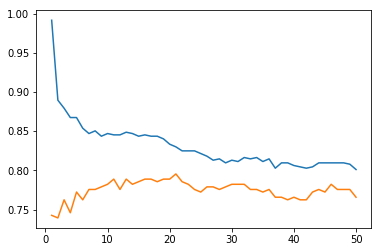

In [126]:
plt.plot( knn_neighbors, accuracy_train, knn_neighbors, accuracy_cv)

In [74]:
# Summarize
model_pred_df = pd.DataFrame( {'Truth': y_cv.values, 'logreg sklearn': log_pred, 
                          'logreg logit': log_pred2, 'lda': lda_pred, 
                            'lin svm': linear_svc_pred, 'gaussian svm': gaussian_svc_pred} )
model_sum_df = pd.DataFrame([ log_sum['accuracy'], 
                             log2_sum['accuracy'], lda_sum['accuracy'], 
                             linear_svc_sum['accuracy'], 
                            gaussian_svc_sum['accuracy'] ], 
                            index = ['log','log2','lda','lin_svm','gauss_svm'])
print( model_sum_df)


                  0
log        0.778878
log2       0.772277
lda        0.798680
lin_svm    0.785479
gauss_svm  0.818482
